## Data/MC Comparison for Brem-Induced Clusters

#### Comparison of Clusters in Data vs MC. This is to validate the signal reconstruction process. We compare cluster from Z->MuMu events in Data vs those from a DY->ZMuMu (50-120 GeV for MLL). Data is from 2023B&C, and MC is from the preBPix, normalized to the appropriate value 

In [167]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"../")
import mplhep as hep
import pickle
import glob
import ROOT as rt
import coffea
import awkward as ak
from coffea import hist, processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector

In [168]:
sys.path.append("/uscms/home/amalbert/nobackup/CMSSW_14_1_0_pre4/src/RazorCommon/Tools/bin")
import importlib
import getMuonScaleFactor

In [169]:
#paths
MC_path = "/store/group/lpclonglived/amalbert/Data_MC_Comp_TnP/results_from_cache_noSkim/MC_noiseFilters/MC_Summer23/DYto2Mu_MLL-50to120_Merged/DYto2Mu_MLL-50to120_18666pb_weighted.root"

data_path_list = ["/store/group/lpclonglived/amalbert/Data_MC_Comp_TnP/results_from_cache_noSkim/Data_noiseFilters/2023_Merged/Muon0_Run2023B_PromptReco-v1_goodLumi.root",
                 "/store/group/lpclonglived/amalbert/Data_MC_Comp_TnP/results_from_cache_noSkim/Data_noiseFilters/2023_Merged/Muon1_Run2023B_PromptReco-v1_goodLumi.root",
                 "/store/group/lpclonglived/amalbert/Data_MC_Comp_TnP/results_from_cache_noSkim/Data_noiseFilters/2023_Merged/Muon0_Run2023C_PromptReco-v1_goodLumi.root",
                 "/store/group/lpclonglived/amalbert/Data_MC_Comp_TnP/results_from_cache_noSkim/Data_noiseFilters/2023_Merged/Muon1_Run2023C_PromptReco-v1_goodLumi.root",
                 "/store/group/lpclonglived/amalbert/Data_MC_Comp_TnP/results_from_cache_noSkim/Data_noiseFilters/2023_Merged/Muon0_Run2023C_PromptReco-v2_goodLumi.root",
                 "/store/group/lpclonglived/amalbert/Data_MC_Comp_TnP/results_from_cache_noSkim/Data_noiseFilters/2023_Merged/Muon1_Run2023C_PromptReco-v2_goodLumi.root",
                 "/store/group/lpclonglived/amalbert/Data_MC_Comp_TnP/results_from_cache_noSkim/Data_noiseFilters/2023_Merged/Muon0_Run2023C_PromptReco-v3_goodLumi.root",
                 "/store/group/lpclonglived/amalbert/Data_MC_Comp_TnP/results_from_cache_noSkim/Data_noiseFilters/2023_Merged/Muon1_Run2023C_PromptReco-v3_goodLumi.root",
                 "/store/group/lpclonglived/amalbert/Data_MC_Comp_TnP/results_from_cache_noSkim/Data_noiseFilters/2023_Merged/Muon0_Run2023C_PromptReco-v4_goodLumi.root",
                 "/store/group/lpclonglived/amalbert/Data_MC_Comp_TnP/results_from_cache_noSkim/Data_noiseFilters/2023_Merged/Muon1_Run2023C_PromptReco-v4_goodLumi.root"]

In [170]:
ak.behavior.update(candidate.behavior)

def getLZDF(f,nEvents=-1,version="new"): #lazy dataframe with events that have cluster matched to probe muon
    events_raw = uproot.open(f)['MuonSystem']
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    #events = events[start:stop]
    return events

In [171]:
#events_data = getLZDF(data_path)
events_MC_full = getLZDF("root://cmseos.fnal.gov/"+MC_path)
events_MC_full = events_MC_full[events_MC_full.nCscRechitClusters>0]
events_MC_full = events_MC_full[events_MC_full.Flag_all]
events_MC_full = events_MC_full[events_MC_full.Flag_ecalBadCalibFilter]
events_MC_full = events_MC_full[events_MC_full.jetVeto]
# events_MC_full = events_MC_full[events_MC_full.cscRechitClusterZ<900]
# events_MC_full = events_MC_full[events_MC_full.cscRechitClusterEta<-1.9]
# events_MC_full = events_MC_full[np.logical_and(events_MC_full.cscRechitClusterPhi>-0.2, cscRechitClusterPhi<0.1)]

In [172]:
data_events = [getLZDF("root://cmseos.fnal.gov/"+data_path) for data_path in data_path_list]

In [173]:
events_data_full = ak.concatenate(data_events, axis=0)

events_data_full = events_data_full[events_data_full.nCscRechitClusters>0]
events_data_full = events_data_full[np.logical_and(events_data_full.ZMass>50, events_data_full.ZMass<120)]
jetVetoArray = events_data_full.jetVeto==1
print(ak.sum(jetVetoArray))
events_data_full = events_data_full[events_data_full.Flag_all]
events_data_full = events_data_full[events_data_full.Flag_ecalBadCalibFilter]
events_data_full = events_data_full[events_data_full.jetVeto]
# events_data_full = events_data_full[events_data_full.cscRechitClusterZ<900]
# events_data_full = events_data_full[events_data_full.cscRechitClusterEta<-1.9]
# events_data_full = events_data_full[np.logical_and(events_data_full.cscRechitClusterPhi>-0.2, cscRechitClusterPhi<0.1)]

2471640


In [174]:
#define cluster level csc branches needed
csc_branches = []
for branch_name in events_MC_full.fields: 
    if "csc" in branch_name and "dt" not in branch_name and "LLP" not in branch_name and "DNN" not in branch_name:
        csc_branches.append(branch_name)
        
branch_names = ["runNum", "evtNum", "weight", "pileupWeight", "ZMass", "met", "metPhi", "puppiMet", "puppiMetPhi"]

In [175]:
def getClusterBranches(LZDF, isMC=False):
    new_df = ak.zip({field: ak.flatten(LZDF[field]) for field in csc_branches})
    print("finished csc branches")
    newDNN = ak.flatten(ak.mask(LZDF["cscRechitClusterDNN_bkgMC_plusBeamHalo"], LZDF["cscRechitClusterDNN_bkgMC_plusBeamHalo"]>0))
    newDNN = newDNN[~ak.is_none(newDNN)]
    new_df = ak.with_field(new_df, newDNN, "cscRechitClusterDNN_bkgMC_plusBeamHalo")
    
    #print("about to start for loop")
    #counts = [range(numClusters) for numClusters in LZDF["nCscRechitClusters"]]
    #print("finished for loop")
    print("finished DNN")
    for branch in branch_names:
        if (not isMC) and (branch in ["weight", "pileupWeight"]):
            continue
        new_df = ak.with_field(new_df, np.repeat(LZDF[branch],LZDF["nCscRechitClusters"]), branch)
    print("finished event level variables")
    
    column_indices_probe = np.array(ak.flatten(ak.values_astype(LZDF["cscRechitCluster_matchToMuon2"], int)))
    column_indices_tag = np.array(ak.flatten(ak.values_astype(LZDF["cscRechitCluster_matchToMuon1"], int)))
    row_indices = np.arange(np.size(column_indices_probe), dtype=int)
    
    
    if isMC:
        MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_preBPix(np.array(LZDF.lepPt), np.array(LZDF.lepEta))
        MC_SF_LooseISO = getMuonScaleFactor.getLooseISOEffArr_preBPix(np.array(LZDF.lepPt), np.array(LZDF.lepEta))
        MC_SF_TightID = getMuonScaleFactor.getTightIDEffArr_preBPix(np.array(LZDF.lepPt), np.array(LZDF.lepEta))
        MC_SF_TightISO = getMuonScaleFactor.getTightISOEffArr_preBPix(np.array(LZDF.lepPt), np.array(LZDF.lepEta))
        MC_SF_HLT = getMuonScaleFactor.getHLTEffArr_preBPix(np.array(LZDF.lepPt), np.array(LZDF.lepEta))
        
        MC_SF_LooseID = np.repeat(MC_SF_LooseID,np.array(LZDF["nCscRechitClusters"]), axis=0)[row_indices,column_indices_probe]
        MC_SF_LooseISO = np.repeat(np.array(MC_SF_LooseISO),np.array(LZDF["nCscRechitClusters"]), axis=0)[row_indices,column_indices_probe]
        MC_SF_TightID = np.repeat(MC_SF_TightID,np.array(LZDF["nCscRechitClusters"]), axis=0)[row_indices,column_indices_tag]
        MC_SF_TightISO = np.repeat(MC_SF_TightISO,np.array(LZDF["nCscRechitClusters"]), axis=0)[row_indices,column_indices_tag]
        MC_SF_HLT = np.repeat(MC_SF_HLT,np.array(LZDF["nCscRechitClusters"]), axis=0)[row_indices,column_indices_tag]
        
        MC_Weight_Total = new_df["weight"]*MC_SF_LooseID*MC_SF_LooseISO*MC_SF_TightID*MC_SF_TightISO*MC_SF_HLT
        new_df = ak.with_field(new_df, MC_Weight_Total, "weight_total")
    
    print("at muon variables")
    #load pT, eta, and phi for tag and probe muons
    probe_pT = np.repeat(np.array(LZDF["lepPt"]),np.array(LZDF["nCscRechitClusters"]), axis=0)[row_indices,column_indices_probe]
    probe_eta = np.repeat(np.array(LZDF["lepEta"]),np.array(LZDF["nCscRechitClusters"]), axis=0)[row_indices,column_indices_probe]
    probe_phi = np.repeat(np.array(LZDF["lepPhi"]),np.array(LZDF["nCscRechitClusters"]), axis=0)[row_indices,column_indices_probe]
    
    tag_pT = np.repeat(np.array(LZDF["lepPt"]),np.array(LZDF["nCscRechitClusters"]), axis=0)[row_indices,column_indices_tag]
    tag_eta = np.repeat(np.array(LZDF["lepEta"]),np.array(LZDF["nCscRechitClusters"]), axis=0)[row_indices,column_indices_tag]
    tag_phi = np.repeat(np.array(LZDF["lepPhi"]),np.array(LZDF["nCscRechitClusters"]), axis=0)[row_indices,column_indices_tag]
    
    new_df = ak.with_field(new_df, probe_pT, "probe_pT")
    new_df = ak.with_field(new_df, probe_eta, "probe_eta")
    new_df = ak.with_field(new_df, probe_phi, "probe_phi")
    
    new_df = ak.with_field(new_df, tag_pT, "tag_pT")
    new_df = ak.with_field(new_df, tag_eta, "tag_eta")
    new_df = ak.with_field(new_df, tag_phi, "tag_phi")
    
    return new_df

In [176]:
print("MC")
events_MC = getClusterBranches(events_MC_full, True)
print("now data")
events_data = getClusterBranches(events_data_full, False)

MC
finished csc branches
finished DNN
finished event level variables
at muon variables
now data
finished csc branches
finished DNN
finished event level variables
at muon variables


In [183]:
forward_hits = events_data.cscRechitClusterNRechitChamberPlus11+events_data.cscRechitClusterNRechitChamberMinus11+events_data.cscRechitClusterNRechitChamberPlus12 + events_data.cscRechitClusterNRechitChamberMinus12
events_data = ak.with_field(events_data, forward_hits, "forward_hits")

forward_hits = events_MC.cscRechitClusterNRechitChamberPlus11+events_MC.cscRechitClusterNRechitChamberMinus11+events_MC.cscRechitClusterNRechitChamberPlus12 + events_MC.cscRechitClusterNRechitChamberMinus12
events_MC = ak.with_field(events_MC, forward_hits, "forward_hits")


In [184]:
#for data
frac_s1_data = (events_data.cscRechitClusterNRechitChamberPlus11+events_data.cscRechitClusterNRechitChamberMinus11+events_data.cscRechitClusterNRechitChamberPlus12+events_data.cscRechitClusterNRechitChamberMinus12+events_data.cscRechitClusterNRechitChamberPlus13+events_data.cscRechitClusterNRechitChamberMinus13)/events_data.cscRechitClusterSize
frac_s2_data = (events_data.cscRechitClusterNRechitChamberPlus21+events_data.cscRechitClusterNRechitChamberMinus21+events_data.cscRechitClusterNRechitChamberPlus22+events_data.cscRechitClusterNRechitChamberMinus22)/events_data.cscRechitClusterSize
frac_s3_data = (events_data.cscRechitClusterNRechitChamberPlus31+events_data.cscRechitClusterNRechitChamberMinus31+events_data.cscRechitClusterNRechitChamberPlus32+events_data.cscRechitClusterNRechitChamberMinus32)/events_data.cscRechitClusterSize
frac_s4_data = (events_data.cscRechitClusterNRechitChamberPlus41+events_data.cscRechitClusterNRechitChamberMinus41+events_data.cscRechitClusterNRechitChamberPlus42+events_data.cscRechitClusterNRechitChamberMinus42)/events_data.cscRechitClusterSize

frac_rw1_data = (events_data.cscRechitClusterNRechitChamberPlus11+events_data.cscRechitClusterNRechitChamberMinus11+events_data.cscRechitClusterNRechitChamberPlus21+events_data.cscRechitClusterNRechitChamberMinus21+events_data.cscRechitClusterNRechitChamberPlus31+events_data.cscRechitClusterNRechitChamberMinus31+events_data.cscRechitClusterNRechitChamberPlus41+events_data.cscRechitClusterNRechitChamberMinus41)/events_data.cscRechitClusterSize
frac_rw2_data = (events_data.cscRechitClusterNRechitChamberPlus12+events_data.cscRechitClusterNRechitChamberMinus12+events_data.cscRechitClusterNRechitChamberPlus22+events_data.cscRechitClusterNRechitChamberMinus22+events_data.cscRechitClusterNRechitChamberPlus32+events_data.cscRechitClusterNRechitChamberMinus32+events_data.cscRechitClusterNRechitChamberPlus42+events_data.cscRechitClusterNRechitChamberMinus42)/events_data.cscRechitClusterSize
frac_rw3_data = (events_data.cscRechitClusterNRechitChamberPlus13+events_data.cscRechitClusterNRechitChamberMinus13)/events_data.cscRechitClusterSize

In [185]:
#for data
frac_s1_MC = (events_MC.cscRechitClusterNRechitChamberPlus11+events_MC.cscRechitClusterNRechitChamberMinus11+events_MC.cscRechitClusterNRechitChamberPlus12+events_MC.cscRechitClusterNRechitChamberMinus12+events_MC.cscRechitClusterNRechitChamberPlus13+events_MC.cscRechitClusterNRechitChamberMinus13)/events_MC.cscRechitClusterSize
frac_s2_MC = (events_MC.cscRechitClusterNRechitChamberPlus21+events_MC.cscRechitClusterNRechitChamberMinus21+events_MC.cscRechitClusterNRechitChamberPlus22+events_MC.cscRechitClusterNRechitChamberMinus22)/events_MC.cscRechitClusterSize
frac_s3_MC = (events_MC.cscRechitClusterNRechitChamberPlus31+events_MC.cscRechitClusterNRechitChamberMinus31+events_MC.cscRechitClusterNRechitChamberPlus32+events_MC.cscRechitClusterNRechitChamberMinus32)/events_MC.cscRechitClusterSize
frac_s4_MC = (events_MC.cscRechitClusterNRechitChamberPlus41+events_MC.cscRechitClusterNRechitChamberMinus41+events_MC.cscRechitClusterNRechitChamberPlus42+events_MC.cscRechitClusterNRechitChamberMinus42)/events_MC.cscRechitClusterSize

frac_rw1_MC = (events_MC.cscRechitClusterNRechitChamberPlus11+events_MC.cscRechitClusterNRechitChamberMinus11+events_MC.cscRechitClusterNRechitChamberPlus21+events_MC.cscRechitClusterNRechitChamberMinus21+events_MC.cscRechitClusterNRechitChamberPlus31+events_MC.cscRechitClusterNRechitChamberMinus31+events_MC.cscRechitClusterNRechitChamberPlus41+events_MC.cscRechitClusterNRechitChamberMinus41)/events_MC.cscRechitClusterSize
frac_rw2_MC = (events_MC.cscRechitClusterNRechitChamberPlus12+events_MC.cscRechitClusterNRechitChamberMinus12+events_MC.cscRechitClusterNRechitChamberPlus22+events_MC.cscRechitClusterNRechitChamberMinus22+events_MC.cscRechitClusterNRechitChamberPlus32+events_MC.cscRechitClusterNRechitChamberMinus32+events_MC.cscRechitClusterNRechitChamberPlus42+events_MC.cscRechitClusterNRechitChamberMinus42)/events_MC.cscRechitClusterSize
frac_rw3_MC = (events_MC.cscRechitClusterNRechitChamberPlus13+events_MC.cscRechitClusterNRechitChamberMinus13)/events_MC.cscRechitClusterSize

In [239]:
def makeEventMask(events, noMaskList: list=[], noCuts=False):
    mask = events.cscRechitCluster_matchToProbeMuon
    #COMMENT OUT IF NOT JUST LOOKING AT HOTSPOT
    #mask=ak.mask(mask, events.cscRechitClusterPhi>-0.4)
    #mask=ak.mask(mask, events.cscRechitClusterPhi<0.2)
    #mask=ak.mask(mask, np.logical_or(np.logical_and(np.logical_or(events.cscRechitClusterPhi<-0.3,events.cscRechitClusterPhi>0.6),abs(events.cscRechitClusterPhi)<2.8), events.cscRechitClusterEta>-1.9))
    #mask=ak.mask(mask, np.logical_and(events.cscRechitClusterPhi<2.8, events.cscRechitClusterPhi>-2.8))
    #mask=ak.mask(mask, abs(events.cscRechitClusterEta)>1.9)
    #mask=ak.mask(mask, events.cscRechitClusterZ<-900)
    ######
    if "forward_veto" not in noMaskList:
        mask = ak.mask(mask, events.forward_hits==0)
    if noCuts:
        return mask
    if "timespread_veto" not in noMaskList:
        mask = ak.mask(mask, events.cscRechitClusterTimeSpreadWeightedAll<20)
    if "time_veto" not in noMaskList:
        mask = ak.mask(mask, events.cscRechitClusterTimeWeighted<12.5)
        mask = ak.mask(mask, events.cscRechitClusterTimeWeighted>-5)
    if "DNN_veto" not in noMaskList:
        mask = ak.mask(mask, events.cscRechitClusterDNN_bkgMC_plusBeamHalo>0.96)
    if "clusterSize_veto" not in noMaskList:
        mask = ak.mask(mask, events.cscRechitClusterSize>160)
    return mask

In [187]:
# data efficiencies
#oneClusterData = ak.mask(events_data, events_data.nCscRechitClusters>0)
#oneClusterData = oneClusterData[~ak.is_none(oneClusterData)]
num = ak.count_nonzero(makeEventMask(events_data))
print("Data Numerator: ", num)

denom_forward = ak.count_nonzero(makeEventMask(events_data, ['forward_veto']))
print("Forward Veto Efficiency: ", num/denom_forward*100)

denom_timespread = ak.count_nonzero(makeEventMask(events_data, ['timespread_veto']))
print("Timespread Veto Efficiency: ", num/denom_timespread*100)

denom_time = ak.count_nonzero(makeEventMask(events_data, ['time_veto']))
print("Time Veto Efficiency: ", num/denom_time*100)

denom_DNN = ak.count_nonzero(makeEventMask(events_data, ['DNN_veto']))
print("DNN Veto Efficiency: ", num/denom_DNN*100)

denom_clusterSize = ak.count_nonzero(makeEventMask(events_data, ['clusterSize_veto']))
print("ClusterSize Veto Efficiency: ", num/denom_clusterSize*100)

denom_total = ak.count_nonzero(makeEventMask(events_data, ['clusterSize_veto', 'timespread_veto', 'DNN_veto', 'time_veto']))
print("Total Efficiency (minus forward veto): ", num/denom_total*100)

Data Numerator:  558
Forward Veto Efficiency:  3.296508536657411
Timespread Veto Efficiency:  84.93150684931507
Time Veto Efficiency:  99.46524064171123
DNN Veto Efficiency:  38.80389429763561
ClusterSize Veto Efficiency:  13.135593220338984
Total Efficiency (minus forward veto):  1.5525444478450794


In [188]:
# data efficiencies
#oneClusterData = ak.mask(events_data, events_data.nCscRechitClusters>0)
#oneClusterData = oneClusterData[~ak.is_none(oneClusterData)]
num = ak.sum(ak.mask(events_MC.weight_total, makeEventMask(events_MC)))
print("MC Numerator: ", num)

denom_forward = ak.sum(ak.mask(events_MC.weight_total, makeEventMask(events_MC,['forward_veto'])))
print("Forward Veto Efficiency: ", num/denom_forward*100)

denom_timespread = ak.sum(ak.mask(events_MC.weight_total, makeEventMask(events_MC,['timespread_veto'])))
print("Timespread Veto Efficiency: ", num/denom_timespread*100)

denom_time = ak.sum(ak.mask(events_MC.weight_total, makeEventMask(events_MC,['time_veto'])))
print("Time Veto Efficiency: ", num/denom_time*100)

denom_DNN = ak.sum(ak.mask(events_MC.weight_total, makeEventMask(events_MC,['DNN_veto'])))
print("DNN Veto Efficiency: ", num/denom_DNN*100)

denom_clusterSize = ak.sum(ak.mask(events_MC.weight_total, makeEventMask(events_MC, ['clusterSize_veto'])))
print("ClusterSize Veto Efficiency: ", num/denom_clusterSize*100)

denom_total = ak.sum(ak.mask(events_MC.weight_total, makeEventMask(events_MC, ['clusterSize_veto', 'timespread_veto', 'DNN_veto', 'time_veto'])))
print("Total Efficiency (minus forward veto): ", num/denom_total*100)

MC Numerator:  1785.9008915184527
Forward Veto Efficiency:  5.951391724447929
Timespread Veto Efficiency:  99.61498180285216
Time Veto Efficiency:  99.61138593690632
DNN Veto Efficiency:  54.806684889268254
ClusterSize Veto Efficiency:  22.638026391751442
Total Efficiency (minus forward veto):  3.9241035924590855


In [190]:
# data efficiencies
print("computing other efficiency definition")
#oneClusterData = ak.mask(events_data, events_data.nCscRechitClusters==1)
#oneClusterData = oneClusterData[~ak.is_none(oneClusterData)]
denom_noForward = ak.count_nonzero(makeEventMask(events_data, ["forward_veto"], True))
print("Data Denominator no forward veto: ", denom_noForward)


denom = ak.count_nonzero(makeEventMask(events_data, [], True))
print("Data Denominator: ", denom)

num_forward = ak.count_nonzero(makeEventMask(events_data, [], True))
print("Forward Veto Efficiency: ", num_forward/denom_noForward*100)

num_timespread = ak.count_nonzero(makeEventMask(events_data, ['clusterSize_veto','DNN_veto','time_veto']))
print("Timespread Veto Efficiency: ", num_timespread/denom*100)

num_time = ak.count_nonzero(makeEventMask(events_data, ['clusterSize_veto','DNN_veto','timespread_veto']))
print("Time Veto Efficiency: ", num_time/denom*100)

num_DNN = ak.count_nonzero(makeEventMask(events_data, ['timespread_veto','clusterSize_veto','time_veto']))
print("DNN Veto Efficiency: ", num_DNN/denom*100)


num_clusterSize = ak.count_nonzero(makeEventMask(events_data, ['timespread_veto','DNN_veto','time_veto']))
print("ClusterSize Veto Efficiency: ", num_clusterSize/denom*100)

computing other efficiency definition
Data Denominator no forward veto:  1979690
Data Denominator:  35941
Forward Veto Efficiency:  1.8154862630007726
Timespread Veto Efficiency:  77.84980940986617
Time Veto Efficiency:  97.96332878884839
DNN Veto Efficiency:  17.581592053643472
ClusterSize Veto Efficiency:  4.671545032136001


In [191]:
# data efficiencies
#oneClusterData = ak.mask(events_data, events_data.nCscRechitClusters>0)
#oneClusterData = oneClusterData[~ak.is_none(oneClusterData)]

denom = ak.sum(ak.mask(events_MC.weight_total, makeEventMask(events_MC, ['forward_veto'], True)))
print("MC Denominator: ", denom)


denom = ak.sum(ak.mask(events_MC.weight_total, makeEventMask(events_MC, [], True)))
print("MC Denominator: ", denom)

num_forward = ak.sum(ak.mask(events_MC.weight_total, makeEventMask(events_MC,[])))
print("Forward Veto Efficiency: ", num_forward/denom*100)

num_timespread = ak.sum(ak.mask(events_MC.weight_total, makeEventMask(events_MC,['clusterSize_veto','DNN_veto','time_veto'])))
print("Timespread Veto Efficiency: ", num_timespread/denom*100)

num_time = ak.sum(ak.mask(events_MC.weight_total, makeEventMask(events_MC,['timespread_veto','clusterSize_veto','DNN_veto'])))
print("Time Veto Efficiency: ", num_time/denom*100)

num_DNN = ak.sum(ak.mask(events_MC.weight_total, makeEventMask(events_MC,['timespread_veto','clusterSize_veto','time_veto'])))
print("DNN Veto Efficiency: ", num_DNN/denom*100)

num_clusterSize = ak.sum(ak.mask(events_MC.weight_total, makeEventMask(events_MC, ['timespread_veto','DNN_veto','time_veto'])))
print("ClusterSize Veto Efficiency: ", num_clusterSize/denom*100)

MC Denominator:  1526925.2573239096
MC Denominator:  45511.05365695244
Forward Veto Efficiency:  3.9241035924590855
Timespread Veto Efficiency:  96.61940932280766
Time Veto Efficiency:  99.06142000586422
DNN Veto Efficiency:  19.225600787151546
ClusterSize Veto Efficiency:  7.20583866430492


### Make Appropriately-Style Plots

In [192]:
rt.gStyle.SetOptStat(0)
def make_ratio_plot(h_list_in, title = "", label = "", fit = False, in_tags = None, ratio_bounds = [0.1, 4], logy = False, ratio_index = 0, draw_opt = ['E2','E1'], text = "", scale=False, scales = [1,1]):
    h_list = []
    if in_tags == None:
        tag = []
    else:
        tag = in_tags
    for i, h in enumerate(h_list_in):
        h_list.append(h.Clone('h{}aux{}'.format(i, label)))
        if in_tags == None:
            tag.append(h.GetTitle())
    #print("tags: ", tag)
    c_out = rt.TCanvas("c_out_ratio"+label, "c_out_ratio"+label, 800, 800)
    pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
    pad1.SetBottomMargin(0.03)
    pad1.SetLeftMargin(0.15)
    pad1.SetRightMargin(0.04)# pad2.SetGrid()
    if logy:
        pad1.SetLogy()

    pad1.Draw()
    pad1.cd()

    leg = rt.TLegend(0.5, 0.65, 0.9, 0.92)
    leg = rt.TLegend(0.7, 0.65, 0.9, 0.92)

    #leg = rt.TLegend(0.2, 0.7, 0.5, 0.9)
    # leg = rt.TLegend(0.7, 0.2, 0.9, 0.4)
    leg.SetBorderSize(0)
    leg.SetTextSize(0.045)
    leg.SetFillStyle(0)
    c_out.cd(1)

    scaled_h_list = []
    if scale:
        for i, h_unscaled in enumerate(h_list):
            #h = h_unscaled.Clone()
            #h = h_unscaled.Scale(1/scales[i])
            #scaled_h_list.append(h_unscaled.Clone())
            h_unscaled.Scale(1/scales[i])
            scaled_h_list.append(h_unscaled)
    else:
        #for i, h_unscaled in enumerate(h_list):
            #h = h_unscaled.Clone()
            #scaled_h_list.append(h)
        scaled_h_list = h_list
    for i, h in enumerate(scaled_h_list):
        h.GetXaxis().SetLabelSize(0)
        h.GetXaxis().SetTitle(label)
        h.GetYaxis().SetRangeUser(0, 1.1*max(map(lambda x: x.GetMaximum(), scaled_h_list)))
        if logy and not scale:
            h.GetYaxis().SetRangeUser(10e-2, 2*max(map(lambda x: x.GetMaximum(), scaled_h_list)))
        if logy and scale:
            h.GetYaxis().SetRangeUser(10e-4, 1)
        h.GetYaxis().SetTitleOffset(1.0)
        h.GetYaxis().SetTitleSize(0.06)
        h.GetYaxis().SetLabelSize(0.05)
        
        if scale:
            y_title = "Fraction of Events"
        else:
            y_title = "Events"
        
        h.GetYaxis().SetTitle()
        h.SetTitle(f"{title};adsf;{y_title}")
        #if ratio_index == 0:h.DrawCopy("hist")
        '''
        h.SetFillColor(h_list_in[i].GetLineColor())
        h.SetFillStyle(3002)
        #h.SetStats(1)
        h.SetLineColor(h_list_in[i].GetLineColor())
        h.SetLineWidth(2)
        h.SetMarkerColor(h_list_in[i].GetLineColor())
        h.SetMarkerSize(2)
        # if ratio_index == 0:
        #     # h.DrawCopy("hist")
        #     h.DrawCopy(draw_opt[i]+'same')
        # else:h.DrawCopy(draw_opt[i])
        #if ratio_index == 0 :h.DrawCopy(draw_opt[i]+"same")
        #h.DrawCopy("E2 HIST")
        '''
        if i==0:
            h.SetLineWidth(4)
            h.DrawCopy("hist")
            #h.SetFillStyle(0)
            h.SetFillColor(h_list_in[i].GetLineColor())
            h.SetFillStyle(3002)
            #h.SetStats(1)
            h.SetLineColor(h_list_in[i].GetLineColor())
            h.SetLineWidth(2)
            h.SetMarkerColor(h_list_in[i].GetLineColor())
            h.SetMarkerSize(2)
            h.DrawCopy(draw_opt[i] + "same")
            #h.SetFillStyle(0)
        else:
            h.SetLineWidth(2)
            h.DrawCopy(draw_opt[i] + "same")
        #else:h.DrawCopy(draw_opt[i])
        if len(text)>0:
            l = rt.TLatex()
            l.SetTextSize(0.045)
            if logy:l.DrawLatex((h.GetXaxis().GetXmax()-h.GetXaxis().GetXmin())*0.1+h.GetXaxis().GetXmin() , h.GetMaximum()/10, text)
            else:l.DrawLatex((h.GetXaxis().GetXmax()-h.GetXaxis().GetXmin())*0.1+h.GetXaxis().GetXmin() , h.GetMaximum()*0.8, text)
        #if i==1:
            #h.DrawCopy(draw_opt[i]+"same")
       #     h.Draw("E1 same")

        leg.AddEntry(h, tag[i], "lep")
    leg.Draw("same")

    c_out.cd()
    pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
    pad2.SetTopMargin(0.03)
    pad2.SetBottomMargin(0.25)
    pad2.SetLeftMargin(0.15)
    pad2.SetRightMargin(0.04)# pad2.SetGrid()
    pad2.Draw()
    pad2.cd()
    band = scaled_h_list[ratio_index].Clone('h_band')
    for j in range(band.GetXaxis().GetNbins()):
        band.SetBinContent(j+1, 1.0)
        if h_list[ratio_index].GetBinContent(j+1) == 0:
            band.SetBinError(j+1, 0.0)
        else:
            band.SetBinError(j+1, scaled_h_list[ratio_index].GetBinError(j+1)/scaled_h_list[ratio_index].GetBinContent(j+1))
            #print(j, h_list_in[0].GetBinError(j+1)/h_list_in[0].GetBinContent(j+1))
    band.SetFillColor(scaled_h_list[ratio_index].GetLineColor())

    band.SetFillStyle(3002)
    band.SetLineColor(scaled_h_list[ratio_index].GetLineColor())
    #band.SetFillColorAlpha(0,0)
    #band.SetLineColor(0)
    
    band.GetYaxis().SetTitleOffset(0.5)
    band.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
    band.GetYaxis().SetTitleSize(0.11)
    band.GetYaxis().SetLabelSize(0.12)
    band.GetYaxis().SetNdivisions(506)
    band.GetXaxis().SetTitleOffset(0.95)
    band.GetXaxis().SetTitleSize(0.12)
    band.GetXaxis().SetLabelSize(0.12)
    band.GetXaxis().SetTickSize(0.07)
    
    band.SetYTitle('Ratio with {}'.format(tag[ratio_index]))
    band.SetXTitle(label)
    band.SetTitle("")
    band.DrawCopy('E2')
    ln = rt.TLine(h.GetXaxis().GetXmin(), 1, h.GetXaxis().GetXmax(), 1)
    ln.SetLineWidth(3)
    ln.SetLineColor(scaled_h_list[ratio_index].GetLineColor())
    ln.DrawLine(h.GetXaxis().GetXmin(), 1, h.GetXaxis().GetXmax(), 1)
     
    #print(ratio_index)
    for i, h in enumerate(scaled_h_list):
        if i == ratio_index:
            continue
        else:
            if fit:h.GetFunction("expo")
            h.Divide(scaled_h_list[ratio_index])
            # h.GetYaxis().SetTitleOffset(0.6)
            # h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
            # h.GetYaxis().SetTitleSize(0.12)
            # h.GetYaxis().SetLabelSize(0.12)
            # h.GetYaxis().SetNdivisions(506)
            # h.GetXaxis().SetTitleOffset(0.95)
            # h.GetXaxis().SetTitleSize(0.12)
            # h.GetXaxis().SetLabelSize(0.12)
            # h.GetXaxis().SetTickSize(0.07)
            # h.SetYTitle('Ratio with {}'.format(tag[0]))
            # h.SetTitle("")
            #set relative error of ratio to be the relative error of data
            for j in range(h.GetXaxis().GetNbins()):
                if h_list[i].GetBinContent(j+1) == 0:
                    h.SetBinError(j+1, 0.0)
                else:
                    h.SetBinError(j+1, h_list_in[i].GetBinError(j+1)/h_list_in[i].GetBinContent(j+1)*h.GetBinContent(j+1))
            h.Draw('same'+draw_opt[i])
    
    pad2.Update()
    
    c_out.pad1 = pad1
    c_out.pad2 = pad2
    c_out.h_list = h_list
    c_out.leg = leg
    
    return c_out

### run number vs cluster time

Text(0.5, 1.0, 'Run # vs Cluster TimeSpread')

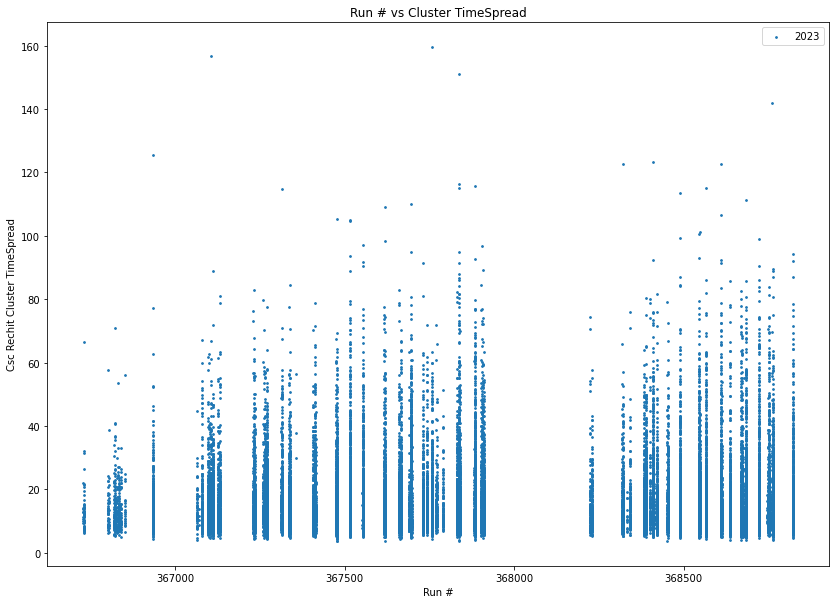

In [193]:
plt.figure(figsize=(14,10))
data_mask = makeEventMask(events_data, [], True)
data_tree = events_data[data_mask]
data_tree = data_tree[~ak.is_none(data_tree)]
data_runNum = data_tree["runNum"]
data_timespread = data_tree["cscRechitClusterTimeSpreadWeightedAll"]
plt.scatter(data_runNum, data_timespread, s=3, label="2023")

plt.legend()
plt.xlabel("Run #")
plt.ylabel("Csc Rechit Cluster TimeSpread")
plt.title("Run # vs Cluster TimeSpread")

Text(0.5, 1.0, 'MET vs Cluster TimeSpread')

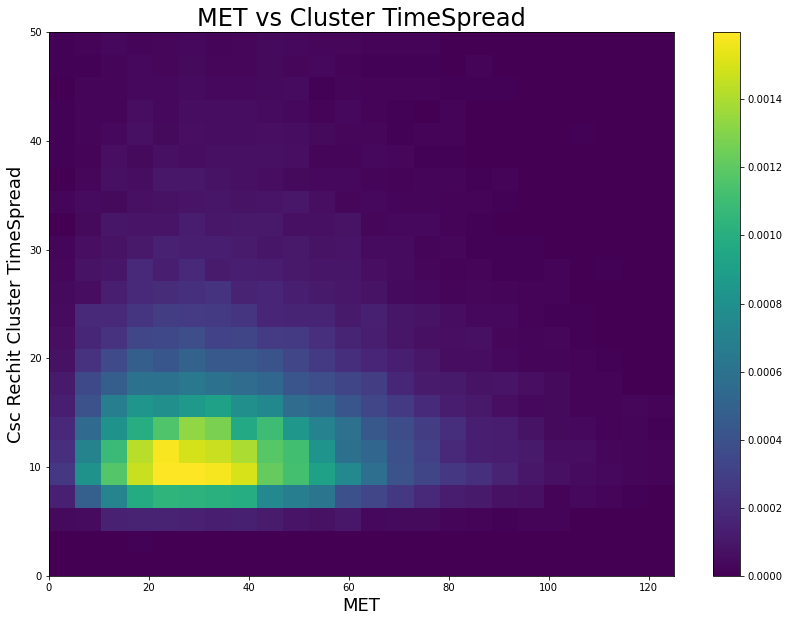

In [194]:
plt.figure(figsize=(14,10))
data_mask = makeEventMask(events_data, [], True)
data_tree = events_data[data_mask]
data_tree = data_tree[~ak.is_none(data_tree)]
data_runNum = data_tree["met"]
data_timespread = data_tree["cscRechitClusterTimeSpreadWeightedAll"]
plt.hist2d(data_runNum, data_timespread, bins=[np.linspace(0, 125, 25),np.linspace(0,50,25)], density=True)
plt.colorbar()
plt.xlabel("MET", fontsize=18)
plt.ylabel("Csc Rechit Cluster TimeSpread", fontsize=18)
plt.title("MET vs Cluster TimeSpread", fontsize=24)

Text(0.5, 1.0, 'Cluster Phi vs Cluster TimeSpread')

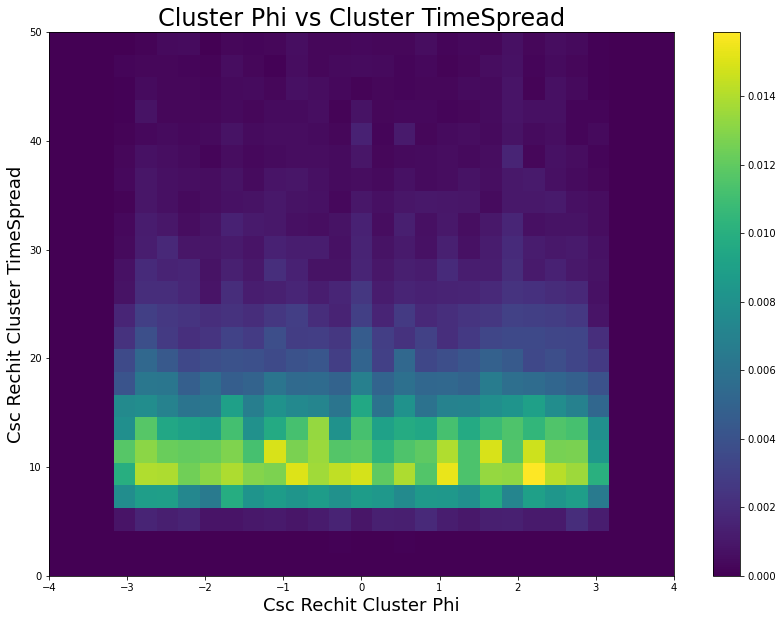

In [195]:
plt.figure(figsize=(14,10))
data_mask = makeEventMask(events_data, [], True)
data_tree = events_data[data_mask]
data_tree = data_tree[~ak.is_none(data_tree)]
data_runNum = data_tree["cscRechitClusterPhi"]
data_timespread = data_tree["cscRechitClusterTimeSpreadWeightedAll"]
plt.hist2d(data_runNum, data_timespread, bins=[np.linspace(-4, 4, 30),np.linspace(0,50,25)], density=True)
plt.colorbar()
plt.xlabel("Csc Rechit Cluster Phi", fontsize=18)
plt.ylabel("Csc Rechit Cluster TimeSpread", fontsize=18)
plt.title("Cluster Phi vs Cluster TimeSpread", fontsize=24)

Text(0.5, 1.0, 'Cluster Eta vs Cluster TimeSpread')

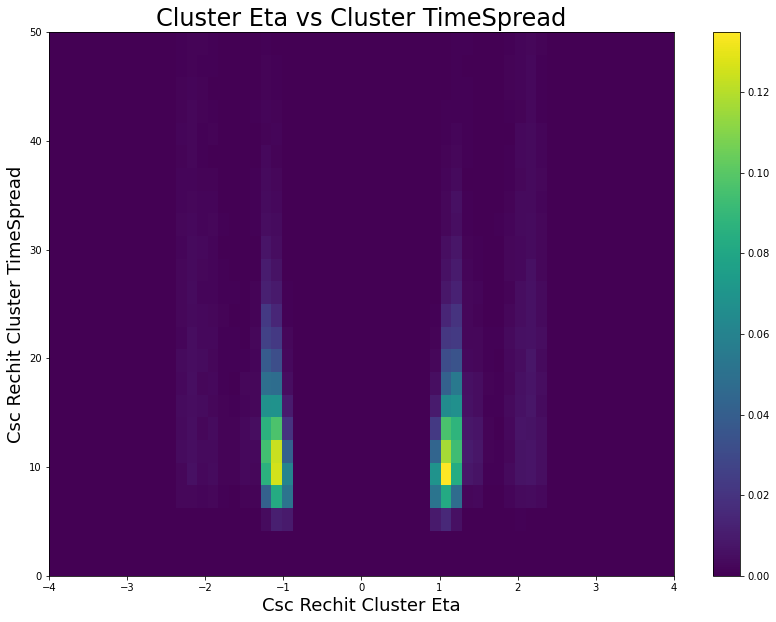

In [196]:
plt.figure(figsize=(14,10))
data_mask = makeEventMask(events_data, [], True)
data_tree = events_data[data_mask]
data_tree = data_tree[~ak.is_none(data_tree)]
data_runNum = data_tree["cscRechitClusterEta"]
data_timespread = data_tree["cscRechitClusterTimeSpreadWeightedAll"]
plt.hist2d(data_runNum, data_timespread, bins=[np.linspace(-4, 4, 60),np.linspace(0,50,25)], density=True)
plt.colorbar()
plt.xlabel("Csc Rechit Cluster Eta", fontsize=18)
plt.ylabel("Csc Rechit Cluster TimeSpread", fontsize=18)
plt.title("Cluster Eta vs Cluster TimeSpread", fontsize=24)

Text(0.5, 1.0, 'Cluster Phi vs Cluster Z')

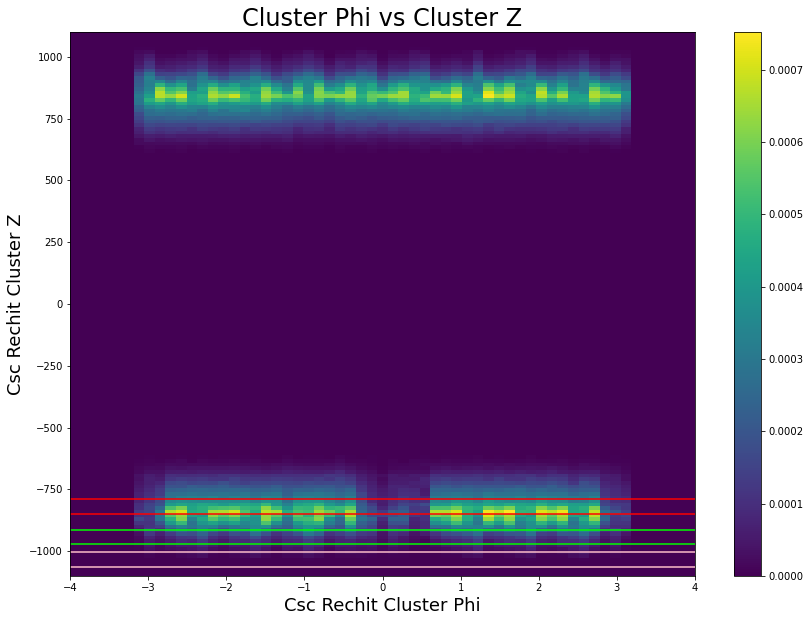

In [197]:
plt.figure(figsize=(14,10))
ax = plt.gca()
data_mask = makeEventMask(events_data, ["forward_veto"], True)
data_tree = events_data[data_mask]
data_tree = data_tree[~ak.is_none(data_tree)]
data_runNum = data_tree["cscRechitClusterPhi"]
data_timespread = data_tree["cscRechitClusterZ"]
plt.hist2d(data_runNum, data_timespread, bins=[np.linspace(-4, 4, 60),np.linspace(-1100,1100,150)], density=True)
plt.colorbar()
plt.xlabel("Csc Rechit Cluster Phi", fontsize=18)
plt.ylabel("Csc Rechit Cluster Z", fontsize=18)
ax.hlines(y=-789, xmin=-4, xmax=4, color="red")
ax.hlines(y=-850, xmin=-4, xmax=4, color="red")
ax.hlines(y=-915, xmin=-4, xmax=4, color="lime")
ax.hlines(y=-970, xmin=-4, xmax=4, color="lime")
ax.hlines(y=-1002, xmin=-4, xmax=4, color="pink")
ax.hlines(y=-1063, xmin=-4, xmax=4, color="pink")

plt.title("Cluster Phi vs Cluster Z", fontsize=24)

Text(0.5, 1.0, 'Cluster Eta vs Cluster Phi')

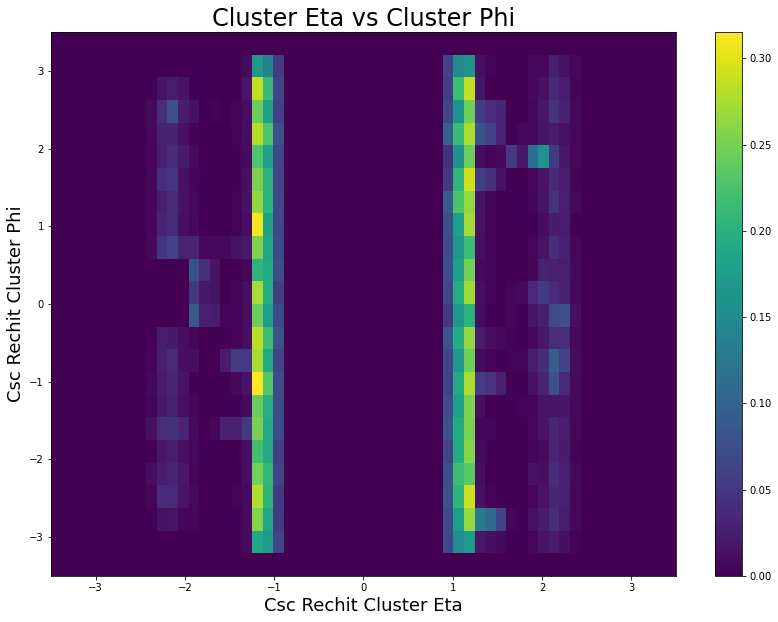

In [163]:
plt.figure(figsize=(14,10))
data_mask = makeEventMask(events_data, [], True)
data_tree = events_data[data_mask]
data_tree = data_tree[~ak.is_none(data_tree)]
data_runNum = data_tree["cscRechitClusterEta"]
data_timespread = data_tree["cscRechitClusterPhi"]
plt.hist2d(data_runNum, data_timespread, bins=[np.linspace(-3.5, 3.5, 60),np.linspace(-3.5,3.5,25)], density=True)
plt.colorbar()
plt.xlabel("Csc Rechit Cluster Eta", fontsize=18)
plt.ylabel("Csc Rechit Cluster Phi", fontsize=18)
plt.title("Cluster Eta vs Cluster Phi", fontsize=24)

Text(0.5, 1.0, 'Met Phi vs Cluster Phi')

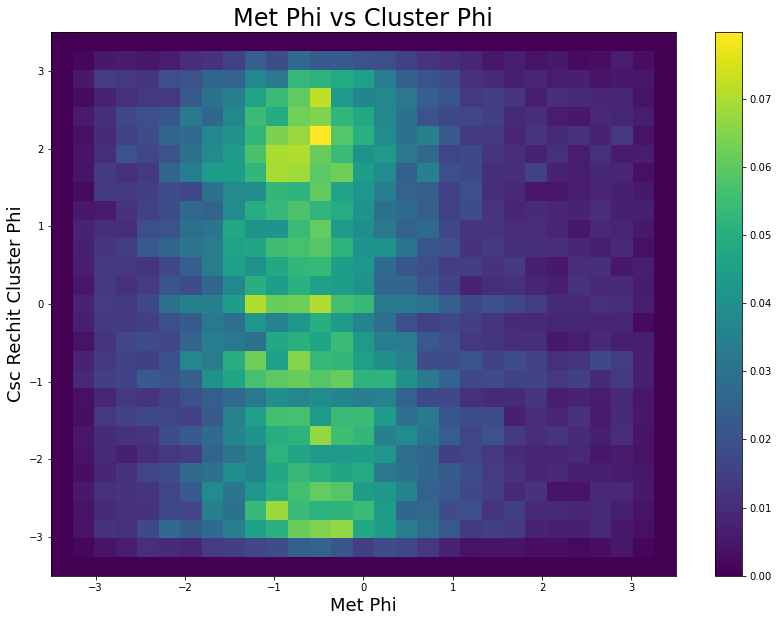

In [164]:
plt.figure(figsize=(14,10))
data_mask = makeEventMask(events_data, [], True)
data_tree = events_data[data_mask]
data_tree = data_tree[~ak.is_none(data_tree)]
data_runNum = data_tree["metPhi"]
data_timespread = data_tree["cscRechitClusterPhi"]
plt.hist2d(data_runNum, data_timespread, bins=[np.linspace(-3.5, 3.5, 30),np.linspace(-3.5,3.5,30)], density=True)
plt.colorbar()
plt.xlabel("Met Phi", fontsize=18)
plt.ylabel("Csc Rechit Cluster Phi", fontsize=18)
plt.title("Met Phi vs Cluster Phi", fontsize=24)

Text(0.5, 1.0, 'Met vs Cluster Phi')

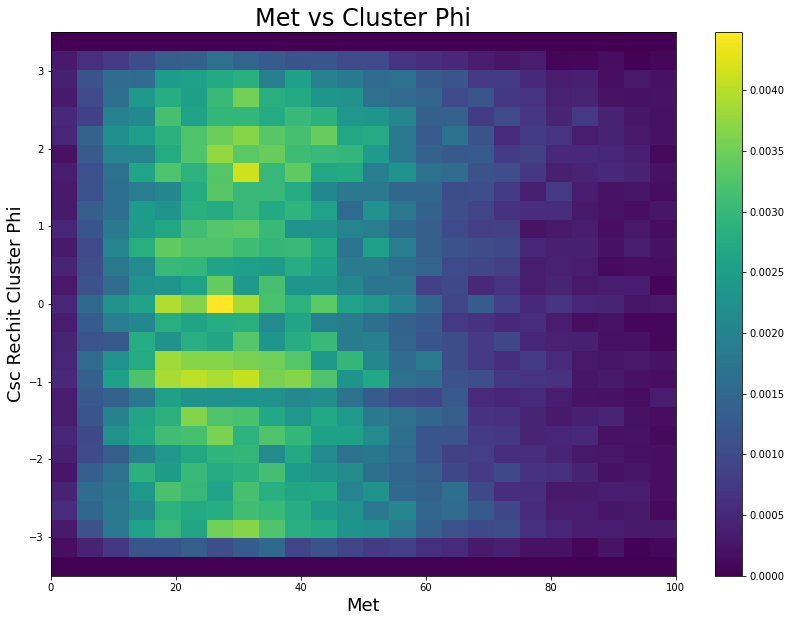

In [165]:
plt.figure(figsize=(14,10))
data_mask = makeEventMask(events_data, [], True)
data_tree = events_data[data_mask]
data_tree = data_tree[~ak.is_none(data_tree)]
data_runNum = data_tree["met"]
data_timespread = data_tree["cscRechitClusterPhi"]
plt.hist2d(data_runNum, data_timespread, bins=[np.linspace(0, 100, 25),np.linspace(-3.5,3.5,30)], density=True)
plt.colorbar()
plt.xlabel("Met", fontsize=18)
plt.ylabel("Csc Rechit Cluster Phi", fontsize=18)
plt.title("Met vs Cluster Phi", fontsize=24)

### Compute MC Scale Factors


### Compute Hit Fraction Variables (DNN input variable)

### Make Data/MC Plots

In [240]:
import os
plot_info = {}
plot_output = "Run2023_preBPix_Data_MC_Comp_withFlags_noVeto_puppiMET"
os.makedirs(plot_output, exist_ok=True)

In [201]:
branch = "cluster_muon_deltaR"
name = branch+"_noCuts_noForwardVeto"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=50, xlow = 0, xup=0.5)

mask = makeEventMask(events_data, ["forward_veto"], True)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(np.sqrt((entry["cscRechitClusterEta"]-entry["probe_eta"])**2+(entry["cscRechitClusterPhi"]-entry["probe_phi"])**2))
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=50, xlow = 0, xup=0.5)
mask = makeEventMask(events_MC, ["forward_veto"], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(np.sqrt((entry["cscRechitClusterEta"]-entry["probe_eta"])**2+(entry["cscRechitClusterPhi"]-entry["probe_phi"])**2), entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "deltaR(cluster, muon)", "label": "deltaR", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [199]:
branch = "cluster_muon_deltaR"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=50, xlow = 0, xup=0.5)

mask = makeEventMask(events_data, [], True)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(np.sqrt((entry["cscRechitClusterEta"]-entry["probe_eta"])**2+(entry["cscRechitClusterPhi"]-entry["probe_phi"])**2))
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=50, xlow = 0, xup=0.5)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(np.sqrt((entry["cscRechitClusterEta"]-entry["probe_eta"])**2+(entry["cscRechitClusterPhi"]-entry["probe_phi"])**2), entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "deltaR(cluster, muon)", "label": "deltaR", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [200]:
branch = "cluster_muon_deltaR"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=50, xlow = 0, xup=0.5)

mask = makeEventMask(events_data, [])
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(np.sqrt((entry["cscRechitClusterEta"]-entry["probe_eta"])**2+(entry["cscRechitClusterPhi"]-entry["probe_phi"])**2))
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=50, xlow = 0, xup=0.5)
mask = makeEventMask(events_MC, [])
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(np.sqrt((entry["cscRechitClusterEta"]-entry["probe_eta"])**2+(entry["cscRechitClusterPhi"]-entry["probe_phi"])**2), entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "deltaR(cluster, muon)", "label": "deltaR", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [143]:
branch = "forward_hits"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=100, xlow = 0, xup=100)

mask = makeEventMask(events_data, ["forward_veto"], True)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=100, xlow = 0, xup=100)
mask = makeEventMask(events_MC, ["forward_veto"], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Number of Rechits in ME11/12", "label": "N_{rechits}", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [144]:
branch = "forward_hits"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=100, xlow = 0, xup=100)

mask = makeEventMask(events_data, ["forward_veto"])
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=100, xlow = 0, xup=100)
mask = makeEventMask(events_MC, ["forward_veto"])
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Number of Rechits in ME11/12", "label": "N_{rechits}", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [245]:
branch = "met"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -5, xup=200)

mask = makeEventMask(events_data)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -5, xup=200)
mask = makeEventMask(events_MC)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "MET", "label": "MET [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [246]:
branch = "met"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -5, xup=200)

mask = makeEventMask(events_data, [], True)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -5, xup=200)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "MET", "label": "MET [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [247]:
branch = "puppiMet"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -5, xup=200)

mask = makeEventMask(events_data)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -5, xup=200)
mask = makeEventMask(events_MC)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Puppi MET", "label": "MET [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [248]:
branch = "puppiMet"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -5, xup=200)

mask = makeEventMask(events_data, [], True)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -5, xup=200)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Puppi MET", "label": "MET [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [249]:
branch = "metPhi"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=30, xlow = -4, xup=4)

mask = makeEventMask(events_data)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_MC)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "MET Phi", "label": "MET Phi", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [250]:
branch = "metPhi"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=30, xlow = -4, xup=4)

mask = makeEventMask(events_data, [], True)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "MET", "label": "MET Phi", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [251]:
branch = "puppiMetPhi"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=30, xlow = -4, xup=4)

mask = makeEventMask(events_data)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_MC)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Puppi MET Phi", "label": "MET Phi", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [252]:
branch = "puppiMetPhi"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=30, xlow = -4, xup=4)

mask = makeEventMask(events_data, [], True)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Puppi MET Phi", "label": "MET Phi", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [149]:
branch = "ZMass"
name = branch+"no_forward_veto"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=80, xlow = 0, xup=150)

mask = makeEventMask(events_data, ["forward_veto"], True)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=80, xlow = 0, xup=150)
mask = makeEventMask(events_MC, ["forward_veto"], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Z Candidate Mass", "label": "Z Candidate Mass [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [205]:
branch = "ZMass"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=80, xlow = 0, xup=150)

mask = makeEventMask(events_data)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=80, xlow = 0, xup=150)
mask = makeEventMask(events_MC)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Z Candidate Mass", "label": "Z Candidate Mass [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [206]:
branch = "ZMass"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=80, xlow = 0, xup=150)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=80, xlow = 0, xup=150)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Z Candidate Mass", "label": "Z Candidate Mass [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [207]:
branch = "probe_pT"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=100)

mask = makeEventMask(events_data)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=100)
mask = makeEventMask(events_MC)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Probe Muon pT", "label": "pT [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [208]:
branch = "probe_pT"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=100)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=100)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Probe Muon pT", "label": "pT [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [209]:
branch = "probe_eta"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -4, xup=4)

mask = makeEventMask(events_data)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_MC)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Probe Muon Eta", "label": "Eta", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [210]:
branch = "probe_eta"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Probe Muon Eta", "label": "Eta", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [211]:
branch = "probe_phi"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -4, xup=4)

mask = makeEventMask(events_data)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_MC)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Probe Muon Phi", "label": "Phi", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [212]:
branch = "probe_phi"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Probe Muon Phi", "label": "Phi", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [213]:
branch = "tag_pT"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=100)

mask = makeEventMask(events_data)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=100)
mask = makeEventMask(events_MC)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Tag Muon pT", "label": "pT [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [214]:
branch = "tag_pT"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=100)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=100)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Tag Muon pT", "label": "pT [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [215]:
branch = "tag_eta"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -4, xup=4)

mask = makeEventMask(events_data)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_MC)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Tag Muon Eta", "label": "Eta", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [216]:
branch = "tag_eta"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Tag Muon Eta", "label": "Eta", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [217]:
branch = "tag_phi"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=30, xlow = -4, xup=4)

mask = makeEventMask(events_data)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_MC)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Tag Muon Phi", "label": "Phi", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [218]:
branch = "tag_phi"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Tag Muon Phi", "label": "Phi", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [219]:
branch = "cscRechitClusterMuonVetoPt"
name = "MuonVetoPt"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=100)

mask = makeEventMask(events_data)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=100)
mask = makeEventMask(events_MC)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Pt of Cluster-Matched Muon", "label": "pT [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [220]:
branch = "cscRechitClusterMuonVetoPt"
name = "MuonVetoPt_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=100)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=100)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Pt of Cluster-Matched Muon", "label": "pT [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [221]:
branch = "cscRechitClusterSize"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=40, xlow = 0, xup=400)

mask = makeEventMask(events_data, "clusterSize_veto")
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=40, xlow = 0, xup=400)
mask = makeEventMask(events_MC,  "clusterSize_veto")
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Size", "label": "N_{rechits}", "scales": [sumOfWeights, data.GetEntries()], "logy": True}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [222]:
branch = "cscRechitClusterSize"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=40, xlow = 0, xup=400)
mask = makeEventMask(events_data, ["clusterSize_veto"], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=40, xlow = 0, xup=400)
mask = makeEventMask(events_MC, ["clusterSize_veto"], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Size", "label": "N_{rechits}", "scales": [sumOfWeights, data.GetEntries()], "logy": True}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [223]:
branch = "cscRechitClusterTimeWeighted"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -8, xup=20)

mask = makeEventMask(events_data, "time_veto")
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -8, xup=20)
mask = makeEventMask(events_MC,  "time_veto")
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Weighted Cluster Time", "label": "Weighted Cluster Time [ns]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [224]:
branch = "cscRechitClusterTimeWeighted"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -8, xup=20)
mask = makeEventMask(events_data, ["time_veto"], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -8, xup=20)
mask = makeEventMask(events_MC, ["time_veto"], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Weighted Cluster Time", "label": "Weighted Cluster Time [ns]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [225]:
branch = "cscRechitClusterTimeSpreadWeightedAll"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = 0, xup=50)

mask = makeEventMask(events_data, "timespread_veto")
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = 0, xup=50)
mask = makeEventMask(events_MC,  "timespread_veto")
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Weighted Cluster Time Spread", "label": "Weighted Cluster Time Spread [ns]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [226]:
branch = "cscRechitClusterTimeSpreadWeightedAll"
name = branch+"_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = 0, xup=50)
mask = makeEventMask(events_data, ["timespread_veto"], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = 0, xup=50)
mask = makeEventMask(events_MC, ["timespread_veto"], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Weighted Cluster Time Spread", "label": "Weighted Cluster Time Spread [ns]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [172]:
branch = "cscRechitClusterDNN_bkgMC_plusBeamHalo"
name = "DNN_Score_forward_veto"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=11, xlow = 0.5, xup=1.05)

mask = makeEventMask(events_data, ["forward_veto"], True)
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=1, xlow = 0.5, xup=1.05)
mask = makeEventMask(events_MC,  ["forward_veto"], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "DNN Score", "label": "DNN Score", "scales": [sumOfWeights, data.GetEntries()], "logy": True}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [227]:
branch = "cscRechitClusterDNN_bkgMC_plusBeamHalo"
name = "DNN_Score"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=11, xlow = 0.5, xup=1.05)

mask = makeEventMask(events_data, ["DNN_veto"])
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=1, xlow = 0.5, xup=1.05)
mask = makeEventMask(events_MC,  ["DNN_veto"])
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "DNN Score", "label": "DNN Score", "scales": [sumOfWeights, data.GetEntries()], "logy": True}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [228]:
branch = "cscRechitClusterDNN_bkgMC_plusBeamHalo"
name = "DNN_Score_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=11, xlow = 0.5, xup=1.05)
mask = makeEventMask(events_data, ["DNN_veto"], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=11, xlow = 0.5, xup=1.05)
mask = makeEventMask(events_MC, ["DNN_veto"], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "DNN Score", "label": "DNN Score", "scales": [sumOfWeights, data.GetEntries()], "logy": True}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [229]:
branch = "cscRechitClusterEta"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -4, xup=4)

mask = makeEventMask(events_data, [])
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_MC,  [])
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Eta", "label": "Cluster Eta", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [230]:
branch = "cscRechitClusterEta"
name = branch + "_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Eta", "label": "Cluster Eta", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [231]:
branch = "cscRechitClusterPhi"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=30, xlow = -4, xup=4)

mask = makeEventMask(events_data, [])
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_MC,  [])
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Phi", "label": "Cluster Phi", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [232]:
branch = "cscRechitClusterPhi"
name = branch + "_noCuts_noforwardveto"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_data, ["forward_veto"], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_MC, ["forward_veto"], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Phi", "label": "Cluster Phi", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [233]:
branch = "cscRechitClusterPhi"
name = branch + "_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Phi", "label": "Cluster Phi", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [234]:
branch = "cscRechitClusterMet_dPhi"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=30, xlow = -4, xup=4)

mask = makeEventMask(events_data, [])
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_MC,  [])
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "dPhi(Cluster, MET)", "label": "dPhi(Cluster, MET)", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [235]:
branch = "cscRechitClusterMet_dPhi"
name = branch + "_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "dPhi(Cluster, MET)", "label": "dPhi(Cluster, MET)", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [236]:
branch = "cscRechitClusterNStation10"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=5, xlow = 0, xup=5)

mask = makeEventMask(events_data, [])
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]
for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=5, xlow = 0, xup=5)
mask = makeEventMask(events_MC,  [])
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]

MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Number of Stations with >=10 Rechits", "label": "NStation10", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [237]:
branch = "cscRechitClusterNStation10"
name = branch + "_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=5, xlow = 0, xup=5)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
data_tree = events_data[mask]
data_tree = data_tree[~ak.is_none(data_tree)]

for entry in data_tree:
    data.Fill(entry[branch])
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=5, xlow = 0, xup=5)
mask = makeEventMask(events_MC, [], True)
clusterIndex=-1
sumOfWeights=0
MC_tree = events_MC[mask]
MC_tree = MC_tree[~ak.is_none(MC_tree)]
for entry in MC_tree:
    MC.Fill(entry[branch], entry["weight_total"])
    sumOfWeights+=entry["weight_total"]
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Number of Stations with >=10 Rechits", "label": "NStation10", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [253]:
for plot_type, plot_info_dict in plot_info.items():
    print(plot_type)
    print(plot_info_dict)
    for boolScale in [True, False]:
        c = make_ratio_plot([plot_info_dict["MC_hist"], plot_info_dict["data_hist"]], title = plot_info_dict["title"], label = plot_info_dict["label"], fit = False, in_tags = None, ratio_bounds = [0.1, 4], logy = plot_info_dict["logy"], ratio_index = 0, draw_opt = ['E2','E1'], text = "", scale=boolScale, scales = plot_info_dict["scales"])
        if boolScale:
            scaleString = "_normalized"
            #c = make_ratio_plot([plot_info_dict["MC_hist"], plot_info_dict["data_hist"]], title = plot_info_dict["title"], label = plot_info_dict["label"], fit = False, in_tags = None, ratio_bounds = [0.1, 4], logy = False, ratio_index = 0, draw_opt = ['E2 hist','E1'], text = "", scale=boolScale, scales = plot_info_dict["scales"])
        else:
            scaleString=""
        os.makedirs(plot_output+"/"+plot_info_dict["file_name"], exist_ok=True)
        c.SaveAs(plot_output+"/"+plot_info_dict["file_name"]+"/"+plot_info_dict["file_name"]+scaleString+"_updatedTNP.png")
        

puppiMet
{'MC_hist': <cppyy.gbl.TH1F object at 0x149d26800>, 'data_hist': <cppyy.gbl.TH1F object at 0x8862edf0>, 'file_name': 'puppiMet', 'title': 'Puppi MET', 'label': 'MET [GeV]', 'scales': [1799.9406858862053, 599.0], 'logy': False}
puppiMet_noCuts
{'MC_hist': <cppyy.gbl.TH1F object at 0x38b95d40>, 'data_hist': <cppyy.gbl.TH1F object at 0x39641ea0>, 'file_name': 'puppiMet_noCuts', 'title': 'Puppi MET', 'label': 'MET [GeV]', 'scales': [45901.33475055787, 42588.0], 'logy': False}
metPhi
{'MC_hist': <cppyy.gbl.TH1F object at 0x119abdc50>, 'data_hist': <cppyy.gbl.TH1F object at 0x3aadda00>, 'file_name': 'metPhi', 'title': 'MET Phi', 'label': 'MET Phi', 'scales': [1799.9406858862053, 599.0], 'logy': False}
metPhi_noCuts
{'MC_hist': <cppyy.gbl.TH1F object at 0xa7fedcb0>, 'data_hist': <cppyy.gbl.TH1F object at 0x9381f390>, 'file_name': 'metPhi_noCuts', 'title': 'MET', 'label': 'MET Phi', 'scales': [45901.33475055787, 42588.0], 'logy': False}
met
{'MC_hist': <cppyy.gbl.TH1F object at 0x5840

Info in <TCanvas::Print>: png file Run2023_preBPix_Data_MC_Comp_withFlags_noVeto_puppiMET/puppiMet/puppiMet_normalized_updatedTNP.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratioMET [GeV]
Info in <TCanvas::Print>: png file Run2023_preBPix_Data_MC_Comp_withFlags_noVeto_puppiMET/puppiMet/puppiMet_updatedTNP.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratioMET [GeV]
Info in <TCanvas::Print>: png file Run2023_preBPix_Data_MC_Comp_withFlags_noVeto_puppiMET/puppiMet_noCuts/puppiMet_noCuts_normalized_updatedTNP.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratioMET [GeV]
Info in <TCanvas::Print>: png file Run2023_preBPix_Data_MC_Comp_withFlags_noVeto_puppiMET/puppiMet_noCuts/puppiMet_noCuts_updatedTNP.png has been created
Info in <TCanvas::Print>: png file Run2023_preBPix_Data_MC_Comp_withFlags_noVeto_puppiMET/metPhi/metPhi_normalized_updatedTNP.

In [ ]:
branch = "cscRechitClusterSize"
name = "MuonVetoPt"
print("at beginning")
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=50, xlow = 0, xup=500)
print("making mask")
mask = makeEventMask(events_data, [])
print("mask made)", len(mask))
#data_tree = ak.with_field(events_data, mask, "mask")
data_tree = events_data
clusterIndex=-1
print(len(events_data[branch]))
#data_tree = events_data[branch][mask]
print("df masked")
for num, evt in enumerate(data_tree):
    if num%1000==0:
        print(num)
    for i in range(evt.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(evt[branch][i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=50, xlow = 0, xup=500)
clusterIndex=-1
#MC_tree = ak.with_field(events_MC, mask, "mask")
MC_tree = events_MC
for num, evt in enumerate(MC_tree):
    if num%1000==0:
        print(evt)
    for i in range(evt.nCscRechitClusters):
        clusterIndex+=1
        if mask[i]:
            if evt.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = evt.weight*evt.pileupWeight*evt.MC_SF_LooseID[probeIndex]*evt.MC_SF_LooseISO[probeIndex]*evt.MC_SF_TightID[tagIndex]*evt.MC_SF_TightID[tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*evt.MC_SF_HLT[evtNum]
            #print(weight)
            MC.Fill(evt[branch][i], weight)
            sumOfWeights+=weight
num=sumOfWeights   
print("numerator: ", num)
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Muon Veto Pt", "label": "Muon Veto Pt [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterMuonVetoPt"
name = "MuonVetoPt_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=80, xlow = 0, xup=120)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, [], True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=80, xlow = 0, xup=120)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
#num=sumOfWeights   
#print("numerator: ", num)
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Muon Veto Pt", "label": "Muon Veto Pt [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterDNN_bkgMC_plusBeamHalo"
name = "DNNScore"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=50, xlow = 0.5, xup=1.05)
mask = makeEventMask(events_data, ['DNN_veto'])
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, ['DNN_veto'])
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=50, xlow = 0.5, xup=1.05)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "DNN Score", "label": "DNN Score", "scales": [sumOfWeights, data.GetEntries()], "logy": True}

In [ ]:
branch = "cscRechitClusterDNN_bkgMC_plusBeamHalo"
name = "DNNScore_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=50, xlow = 0.5, xup=1.05)
mask = makeEventMask(events_data, ["DNN_veto"], True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, ["DNN_veto"], True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=50, xlow = 0.5, xup=1.05)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            #if MC_tree.lepPt[tagIndex]>26:
            #    weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "DNN Score", "label": "DNN Score", "scales": [sumOfWeights, data.GetEntries()], "logy": True}

In [ ]:
branch = "cscRechitClusterSize"
name = "clusterSize"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=40, xlow = 0, xup=400)
mask = makeEventMask(events_data, ['clusterSize_veto'])
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, ['clusterSize_veto'])
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=40, xlow = 0, xup=400)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
        
MC.SetLineColor(rt.kRed)
print(branch + " efficiency  = ", num/sumOfWeights)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Size", "label": "N_{rechits}", "scales": [sumOfWeights, data.GetEntries()], "logy": True}

In [ ]:
branch = "cscRechitClusterSize"
name = "clusterSize_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=40, xlow = 0, xup=400)
mask = makeEventMask(events_data, ['clusterSize_veto'], True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, ['clusterSize_veto'], True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=40, xlow = 0, xup=400)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
        
MC.SetLineColor(rt.kRed)
print(branch + " efficiency  = ", num/sumOfWeights)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Size", "label": "N_{rechits}", "scales": [sumOfWeights, data.GetEntries()], "logy": True}

In [ ]:
branch = "cscRechitClusterEta"
name = "clusterEta"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_data)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -4, xup=4)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Eta", "label": "Cluster Eta", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterEta"
name = "clusterEta_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -4, xup=4)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, [], True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -4, xup=4)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Eta", "label": "Cluster Eta", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterPhi"
name = "clusterPhi"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_data)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=30, xlow = -4, xup=4)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Phi", "label": "Cluster Phi", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterPhi"
name = "clusterPhi_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=30, xlow = -4, xup=4)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, [], True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=30, xlow = -4, xup=4)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Phi", "label": "Cluster Phi", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterTimeWeighted"
name = "clusterTime"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -8, xup=20)
mask = makeEventMask(events_data, ['time_veto'])
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, ['time_veto'])
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -8, xup=20)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)       
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Weighted Cluster Time", "label": "Weighted Cluster Time [ns]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterTimeWeighted"
name = "clusterTime_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -8, xup=20)
mask = makeEventMask(events_data, ['time_veto'], True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, ['time_veto'], True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -8, xup=20)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)       
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Weighted Cluster Time", "label": "Weighted Cluster Time [ns]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterTimeSpreadWeightedAll"
name = "clusterTimeSpreadWeightedAll"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=50, xlow = -1, xup=40)
mask = makeEventMask(events_data, ["timespread_veto"])
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, ["timespread_veto"])
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=50, xlow = -1, xup=40)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Weighted Cluster Time Spread", "label": "Weighted Cluster Time Spread [ns]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterTimeSpreadWeightedAll"
name = "clusterTimeSpreadWeightedAll_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=50, xlow = -1, xup=40)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, [], True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=50, xlow = -1, xup=40)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Weighted Cluster Time Spread", "label": "Weighted Cluster Time Spread [ns]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterNStation10"
name = "clusterNStation10"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=5, xlow = 0, xup=5)
mask = makeEventMask(events_data)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=5, xlow = 0, xup=5)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Number of Stations with >=10 Rechits", "label": "NStation10", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterNStation10"
name = "clusterNStation10_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=5, xlow = 0, xup=5)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, [], True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=5, xlow = 0, xup=5)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Number of Stations with >=10 Rechits", "label": "NStation10", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterXSpread"
name = "clusterXSpread"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -5, xup=150)
mask = makeEventMask(events_data)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -5, xup=150)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster X Spread", "label": "Cluster X Spread [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterXSpread"
name = "clusterXSpread_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -5, xup=150)
mask = makeEventMask(events_data,[],True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC,[],True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -5, xup=150)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster X Spread", "label": "Cluster X Spread [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterYSpread"
name = "clusterYSpread"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -5, xup=150)
mask = makeEventMask(events_data)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -5, xup=150)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Y Spread", "label": "Cluster Y Spread [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterYSpread"
name = "clusterYSpread_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -5, xup=150)
mask = makeEventMask(events_data,[],True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC,[],True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -5, xup=150)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Y Spread", "label": "Cluster Y Spread [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterZSpread"
name = "clusterZSpread"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -5, xup=200)
mask = makeEventMask(events_data)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -5, xup=200)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Z Spread", "label": "Cluster Z Spread [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterZSpread"
name = "clusterZSpread_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -5, xup=200)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, [], True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -5, xup=200)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Z Spread", "label": "Cluster Z Spread [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterXYSpread"
name = "clusterXYSpread"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -5, xup=150)
mask = makeEventMask(events_data)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -5, xup=150)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster XY Spread", "label": "Cluster XY Spread [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterRSpread"
name = "clusterRSpread"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -5, xup=150)
mask = makeEventMask(events_data)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -5, xup=150)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster R Spread", "label": "Cluster R Spread [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterRSpread"
name = "clusterRSpread_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -5, xup=150)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, [], True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -5, xup=150)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster R Spread", "label": "Cluster R Spread [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterXYSpread"
name = "clusterXYSpread_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -5, xup=150)
mask = makeEventMask(events_data,[],True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC,[],True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -5, xup=150)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster XY Spread", "label": "Cluster XY Spread [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterSkewX"
name = "clusterSkewX"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -150, xup=150)
mask = makeEventMask(events_data)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -150, xup=150)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Skew X", "label": "Cluster X Skew [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterSkewX"
name = "clusterSkewX_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -150, xup=150)
mask = makeEventMask(events_data,[],True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC,[],True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -150, xup=-150)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Skew X", "label": "Cluster X Skew [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterSkewY"
name = "clusterSkewY"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -150, xup=150)
mask = makeEventMask(events_data)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -150, xup=150)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Skew Y", "label": "Cluster Y Skew [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterSkewY"
name = "clusterSkewY_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -150, xup=150)
mask = makeEventMask(events_data,[],True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC,[],True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -150, xup=150)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Skew Y", "label": "Cluster Y Skew [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterSkewZ"
name = "clusterSkewZ"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -150, xup=150)
mask = makeEventMask(events_data)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -150, xup=150)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Skew Z", "label": "Cluster Z Skew [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
branch = "cscRechitClusterSkewZ"
name = "clusterSkewZ_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = -150, xup=150)
mask = makeEventMask(events_data,[],True)
clusterIndex=-1
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC,[],True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = -5, xup=75)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(getattr(MC_tree, branch)[i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Skew Z", "label": "Cluster Z Skew [cm]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
#branch = "cscRechitClusterSkewZ"
name = "clusterFrac_s1_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=1.1)
mask = makeEventMask(events_data,[],True)
clusterIndex=-1
for evtNum, entry in enumerate(data_tree):
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(frac_s1_data[evtNum][i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC,[],True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=1.1)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(frac_s1_MC[evtNum][i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Fraction of Hits in Station 1", "label": "Station 1 Hits/Total Hits", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
#branch = "cscRechitClusterSkewZ"
name = "clusterFrac_s1_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=1.1)
mask = makeEventMask(events_data,[],True)
clusterIndex=-1
for evtNum, entry in enumerate(data_tree):
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(frac_s1_data[evtNum][i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC,[],True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=1.1)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(frac_s1_MC[evtNum][i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Fraction of Hits in Station 1", "label": "Station 2 Hits/Total Hits", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
#branch = "cscRechitClusterSkewZ"
name = "clusterFrac_s2"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=1.1)
mask = makeEventMask(events_data)
clusterIndex=-1
for evtNum, entry in enumerate(data_tree):
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(frac_s2_data[evtNum][i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=1.1)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(frac_s2_MC[evtNum][i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Fraction of Hits in Station 2", "label": "Station 2 Hits/Total Hits", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
#branch = "cscRechitClusterSkewZ"
name = "clusterFrac_s2_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=1.1)
mask = makeEventMask(events_data,[],True)
clusterIndex=-1
for evtNum, entry in enumerate(data_tree):
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(frac_s2_data[evtNum][i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC,[],True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=1.1)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(frac_s2_MC[evtNum][i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Fraction of Hits in Station 2", "label": "Station 2 Hits/Total Hits", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
#branch = "cscRechitClusterSkewZ"
name = "clusterFrac_s3"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=1.1)
mask = makeEventMask(events_data)
clusterIndex=-1
for evtNum, entry in enumerate(data_tree):
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(frac_s3_data[evtNum][i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=1.1)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(frac_s3_MC[evtNum][i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Fraction of Hits in Station 3", "label": "Station 3 Hits/Total Hits", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
#branch = "cscRechitClusterSkewZ"
name = "clusterFrac_s3_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=1.1)
mask = makeEventMask(events_data,[],True)
clusterIndex=-1
for evtNum, entry in enumerate(data_tree):
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(frac_s3_data[evtNum][i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC,[],True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=1.1)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(frac_s3_MC[evtNum][i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Fraction of Hits in Station 3", "label": "Station 3 Hits/Total Hits", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
#branch = "cscRechitClusterSkewZ"
name = "clusterFrac_s4_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=1.1)
mask = makeEventMask(events_data,[],True)
clusterIndex=-1
for evtNum, entry in enumerate(data_tree):
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(frac_s4_data[evtNum][i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC,[],True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=1.1)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(frac_s4_MC[evtNum][i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Fraction of Hits in Station 4", "label": "Station 4 Hits/Total Hits", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
#branch = "cscRechitClusterSkewZ"
name = "clusterFrac_rw1"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=1.1)
mask = makeEventMask(events_data)
clusterIndex=-1
for evtNum, entry in enumerate(data_tree):
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(frac_rw1_data[evtNum][i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=1.1)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(frac_rw1_MC[evtNum][i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Fraction of Hits in Ring 1", "label": "Ring 1 Hits/Total Hits", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
#branch = "cscRechitClusterSkewZ"
name = "clusterFrac_rw1_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=1.1)
mask = makeEventMask(events_data,[],True)
clusterIndex=-1
for evtNum, entry in enumerate(data_tree):
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(frac_rw1_data[evtNum][i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC,[],True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=1.1)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(frac_rw1_MC[evtNum][i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Fraction of Hits in Ring 1", "label": "Ring 1 Hits/Total Hits", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
#branch = "cscRechitClusterSkewZ"
name = "clusterFrac_rw2"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=1.1)
mask = makeEventMask(events_data)
clusterIndex=-1
for evtNum, entry in enumerate(data_tree):
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(frac_rw2_data[evtNum][i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=1.1)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(frac_rw2_MC[evtNum][i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Fraction of Hits in Ring 2", "label": "Ring 2 Hits/Total Hits", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
#branch = "cscRechitClusterSkewZ"
name = "clusterFrac_rw2_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=1.1)
mask = makeEventMask(events_data, [], True)
clusterIndex=-1
for evtNum, entry in enumerate(data_tree):
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(frac_rw2_data[evtNum][i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC, [], True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=1.1)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(frac_rw2_MC[evtNum][i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Fraction of Hits in Ring 2", "label": "Ring 2 Hits/Total Hits", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
#branch = "cscRechitClusterSkewZ"
name = "clusterFrac_rw3"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=1.1)
mask = makeEventMask(events_data)
clusterIndex=-1
for evtNum, entry in enumerate(data_tree):
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(frac_rw3_data[evtNum][i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=1.1)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(frac_rw3_MC[evtNum][i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Fraction of Hits in Ring 3", "label": "Ring 3 Hits/Total Hits", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [ ]:
#branch = "cscRechitClusterSkewZ"
name = "clusterFrac_rw3_noCuts"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=25, xlow = 0, xup=1.1)
mask = makeEventMask(events_data,[],True)
clusterIndex=-1
for evtNum, entry in enumerate(data_tree):
    for i in range(data_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            data.Fill(frac_rw3_data[evtNum][i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
mask = makeEventMask(events_MC,[],True)
#print(ak.count_nonzero(mask[~ak.is_none(mask)]))
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=25, xlow = 0, xup=1.1)
clusterIndex=-1
for evtNum, entry in enumerate(MC_tree):
    for i in range(MC_tree.nCscRechitClusters):
        clusterIndex+=1
        if mask[clusterIndex]:
            if MC_tree.cscRechitCluster_matchToMuon1[i]==1:
                probeIndex=0; tagIndex=1
            else:
                probeIndex=1; tagIndex=0
            weight = getattr(MC_tree, "weight")*getattr(MC_tree, "pileupWeight")*MC_SF_LooseID[evtNum][probeIndex]*MC_SF_LooseISO[evtNum][probeIndex]*MC_SF_TightID[evtNum][tagIndex]*MC_SF_TightID[evtNum][tagIndex]
            #weight = MC_SF_LooseID[evtNum][probeIndex]
            if MC_tree.lepPt[tagIndex]>26:
                weight=weight*MC_SF_HLT[evtNum][tagIndex]
            #print(weight)
            MC.Fill(frac_rw3_MC[evtNum][i], weight)
            sumOfWeights+=weight
print(branch + " efficiency  = ", num/sumOfWeights)        
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Fraction of Hits in Ring 3", "label": "Ring 3 Hits/Total Hits", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

In [35]:
for plot_type, plot_info_dict in plot_info.items():
    print(plot_type)
    #print(plot_info_dict)
    for boolScale in [True, False]:
        c = make_ratio_plot([plot_info_dict["MC_hist"], plot_info_dict["data_hist"]], title = plot_info_dict["title"], label = plot_info_dict["label"], fit = False, in_tags = None, ratio_bounds = [0.1, 4], logy = plot_info_dict["logy"], ratio_index = 0, draw_opt = ['E2','E1'], text = "", scale=boolScale, scales = plot_info_dict["scales"])
        if boolScale:
            scaleString = "_normalized"
            #c = make_ratio_plot([plot_info_dict["MC_hist"], plot_info_dict["data_hist"]], title = plot_info_dict["title"], label = plot_info_dict["label"], fit = False, in_tags = None, ratio_bounds = [0.1, 4], logy = False, ratio_index = 0, draw_opt = ['E2 hist','E1'], text = "", scale=boolScale, scales = plot_info_dict["scales"])
        else:
            scaleString=""
        os.makedirs(plot_output+"/"+plot_info_dict["file_name"], exist_ok=True)
        c.SaveAs(plot_output+"/"+plot_info_dict["file_name"]+"/"+plot_info_dict["file_name"]+scaleString+"_updatedTNP.png")
        

ZMass


ZeroDivisionError: division by zero

#### 